<center><h1  style="color:white; background-color:#000000; border-radius: 0px; padding:25px;"> MGS-GRF </h1></center>

This notebook produces the results from section 4.2.

In [1]:
import os
import sys
sys.path.insert(1, os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
from pathlib import Path
from collections import Counter

import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import precision_score, recall_score, roc_auc_score,balanced_accuracy_score,average_precision_score

from validation.classif_experiments import (compute_metrics, compute_metrics_several_protocols,
                                            prec_at_recall_version3, prec_at_recall_version3_02)

from matplotlib.cm import ScalarMappable

In [2]:
list_metric = [
    (prec_at_recall_version3_02,'p@r=0.2','proba'),
    (prec_at_recall_version3,'p@r=0.5','proba'),
    (average_precision_score,'avg_pr_auc', 'proba'),
    (roc_auc_score,'roc_auc','proba') 
]

In [3]:
def compute_metric_and_incoherent(output_dir,list_metric,curr_metric= "avg_pr_auc",strategy_name = "SmoteNC (K=5)",
                                  n_iter=20,categorical_features= [-2,-1],init_name_file="2027-01-07-lgbm_"):

    list_metric_none=[]
    list_metric_strategy=[]
    list_ncso=[]
    list_ncss=[]
    for i in range(n_iter):
        name_file=init_name_file+str(i)+".npy"
        df_final_mean,df_final_std =compute_metrics(output_dir=output_dir,name_file=name_file,list_metric=list_metric,n_fold=1)
        strategy_value = df_final_mean.loc[[curr_metric],[strategy_name]].to_numpy().ravel()[0]
        none_value = df_final_mean.loc[[curr_metric],['None']].to_numpy().ravel()[0]
        list_metric_none.append(none_value)
        list_metric_strategy.append(strategy_value)
        
        X_train = np.load(os.path.join(output_dir, "xtrain" + name_file),allow_pickle=True)
        y_train = np.load(os.path.join(output_dir, "ytrain" + name_file))
        X_res = np.load(os.path.join(output_dir, "xres" +strategy_name+ name_file),allow_pickle=True)
        y_res = np.load(os.path.join(output_dir, "yres" +strategy_name+ name_file),allow_pickle=True)
        X_train_minority_comb = [str(xxx) for xxx in X_train[y_train==1][:,categorical_features]]
        counter_train = Counter(X_train_minority_comb)
        X_res_minority_comb = [str(xxx) for xxx in X_res[y_res==1][:,categorical_features]]
        counter_res = Counter(X_res_minority_comb)
    
        ncso = 0
        train_keys = counter_train.keys()
        for key in counter_res.keys():
            if key not in train_keys:
                ncso += counter_res[key]
        list_ncso.append(ncso/ sum(counter_res.values())) ## Compute and save ncso
        
        ncss = 0
        n_original = sum(counter_train.values())
        train_keys = counter_train.keys()
        for key in counter_res.keys():
            if key not in train_keys:
                ncss += counter_res[key]
        
        list_ncss.append(ncss / (sum(counter_res.values())-n_original) ) ## Compute and save ncss
    return list_metric_none, list_metric_strategy, list_ncso, list_ncss

## Results over seeral runs :

In [4]:
df_final_mean,df_final_std =compute_metrics(
    output_dir="../saved_experiments_categorial_features/2025-Sim2/normal/lgbm/5ksamples/case6",
    name_file="2027-01-07-lgbm_0.npy",
    list_metric=list_metric,
    n_fold=1)
df_final_mean

,None,CW,ROS,RUS,SmoteNC (K=5),MGS(mu)(d+1)(EmpCov) 1-NN,MGS(mu)(d+1)(EmpCov) 5-NN,MGS-NC(mu)(d+1)(EmpCov),MGS(mu)(d+1)(EmpCov) drf
p@r=0.2,0.230769,0.285714,0.206897,0.057143,0.139535,1.000000,1.000000,0.666667,1.000000
p@r=0.5,0.072165,0.069307,0.073684,0.042169,0.054902,0.777778,0.102941,0.129630,0.933333
avg_pr_auc,0.159893,0.185780,0.168535,0.049989,0.110029,0.715317,0.359301,0.339309,0.793413
roc_auc,0.807963,0.806783,0.768414,0.695558,0.756461,0.954703,0.860378,0.858932,0.966122


In [13]:
output_dir_path =  "../saved_experiments_categorial_features/2025-Sim2/normalv2/lgbm/5ksamples/case2/runtimejobs5/" ## Fill it
df_final_mean_bankmark,df_final_std_bankmark = compute_metrics_several_protocols(
    output_dir=output_dir_path,
    init_name_file='2027-01-07-lgbm_',
    list_metric=list_metric,
    bool_roc_auc_only=False,n_iter=50,n_fold=1)
df_final_mean_bankmark.style.format(precision=3).highlight_max(props='font-weight:bold;color:#090E19', axis = 1)

,None,CW,ROS,RUS,SmoteNC (K=5),MGS(mu)(d+1)(EmpCov) 1-NN,MGS(mu)(d+1)(EmpCov) 5-NN,MGS-NC(mu)(d+1)(EmpCov),MGS(mu)(d+1)(EmpCov) drf,MGS(mu)(d+1)(EmpCov) DRFsk classique (mtry=def=sqrt),MGS(mu)(d+1)(EmpCov) DRFskExtra classique (mtry=def=sqrt)
p@r=0.2,0.994,0.991,0.985,0.883,0.989,0.987,0.982,0.988,0.986,0.991,0.991
p@r=0.5,0.974,0.964,0.961,0.729,0.971,0.980,0.958,0.973,0.978,0.981,0.979
avg_pr_auc,0.903,0.903,0.893,0.699,0.860,0.952,0.870,0.922,0.949,0.954,0.947
roc_auc,0.975,0.977,0.975,0.935,0.962,0.993,0.970,0.984,0.992,0.993,0.991


In [79]:
df_final_std_bankmark.style.format(precision=3).highlight_max(props='font-weight:bold;color:#090E19', axis = 1)

,None,CW,ROS,RUS,SmoteNC (K=5),MGS(mu)(d+1)(EmpCov) 1-NN,MGS(mu)(d+1)(EmpCov) 5-NN,MGS-NC(mu)(d+1)(EmpCov),MGS(mu)(d+1)(EmpCov) drf,MGS(mu)(d+1)(EmpCov) DRFsk classique (mtry=def=sqrt),MGS(mu)(d+1)(EmpCov) DRFskExtra classique (mtry=def=sqrt)
p@r=0.2,0.018,0.023,0.030,0.113,0.019,0.024,0.028,0.026,0.021,0.019,0.018
p@r=0.5,0.039,0.067,0.051,0.166,0.023,0.018,0.047,0.023,0.017,0.020,0.019
avg_pr_auc,0.054,0.055,0.056,0.121,0.041,0.025,0.045,0.030,0.028,0.023,0.027
roc_auc,0.014,0.012,0.014,0.030,0.012,0.005,0.013,0.008,0.007,0.005,0.006


In [5]:
output_dir_path =  "../saved_experiments_categorial_features/2025-Sim2/normalv2/lgbm/5ksamples/case2" ## Fill it
df_final_mean_bankmark,df_final_std_bankmark = compute_metrics_several_protocols(
    output_dir=output_dir_path,
    init_name_file='2027-01-07-lgbm_',
    list_metric=list_metric,
    bool_roc_auc_only=False,n_iter=50,n_fold=1)
df_final_mean_bankmark.style.format(precision=3).highlight_max(props='font-weight:bold;color:#090E19', axis = 1)

,None,CW,ROS,RUS,SmoteNC (K=5),MGS(mu)(d+1)(EmpCov) 1-NN,MGS(mu)(d+1)(EmpCov) 5-NN,MGS-NC(mu)(d+1)(EmpCov),MGS(mu)(d+1)(EmpCov) drf,MGS(mu)(d+1)(EmpCov) DRFsk classique (mtry=def=sqrt),MGS(mu)(d+1)(EmpCov) DRFskExtra classique (mtry=def=sqrt)
p@r=0.2,0.994,0.991,0.985,0.883,0.989,0.987,0.982,0.988,0.986,0.986,0.991
p@r=0.5,0.974,0.964,0.961,0.729,0.971,0.980,0.958,0.973,0.978,0.984,0.979
avg_pr_auc,0.903,0.903,0.893,0.699,0.860,0.952,0.870,0.922,0.950,0.957,0.947
roc_auc,0.975,0.977,0.975,0.935,0.962,0.993,0.970,0.984,0.992,0.994,0.991


In [6]:
df_final_std_bankmark.style.format(precision=3).highlight_max(props='font-weight:bold;color:#090E19', axis = 1)

,None,CW,ROS,RUS,SmoteNC (K=5),MGS(mu)(d+1)(EmpCov) 1-NN,MGS(mu)(d+1)(EmpCov) 5-NN,MGS-NC(mu)(d+1)(EmpCov),MGS(mu)(d+1)(EmpCov) drf,MGS(mu)(d+1)(EmpCov) DRFsk classique (mtry=def=sqrt),MGS(mu)(d+1)(EmpCov) DRFskExtra classique (mtry=def=sqrt)
p@r=0.2,0.018,0.023,0.030,0.113,0.019,0.024,0.028,0.026,0.021,0.023,0.018
p@r=0.5,0.039,0.067,0.051,0.166,0.023,0.018,0.047,0.023,0.017,0.016,0.019
avg_pr_auc,0.054,0.055,0.056,0.121,0.041,0.025,0.045,0.030,0.028,0.019,0.027
roc_auc,0.014,0.012,0.014,0.030,0.012,0.005,0.013,0.008,0.007,0.004,0.006


In [27]:
list_metric_none1, list_metric_strategy1, list_ncso1, list_ncss1 = compute_metric_and_incoherent(
    output_dir="../saved_experiments_categorial_features/2025-Sim2/normalv2/lgbm/5ksamples/case2",
    list_metric=list_metric,curr_metric= "avg_pr_auc",strategy_name = "SmoteNC (K=5)", #MGS(mu)(d+1)(EmpCov) 5-NN #SmoteNC (K=5)
    n_iter=50,categorical_features= [-2,-1],init_name_file="2027-01-07-lgbm_")
print("Mean CSO for this case : ",np.mean(list_ncss1))
print("std : ",np.std(list_ncss1))

Mean CSO for this case :  0.09786846603847063
std :  0.013122494219156943


In [28]:
list_metric_none1, list_metric_strategy1, list_ncso1, list_ncss1 = compute_metric_and_incoherent(
    output_dir="../saved_experiments_categorial_features/2025-Sim2/normalv2/lgbm/5ksamples/case2",
    list_metric=list_metric,curr_metric= "avg_pr_auc",strategy_name = "MGS(mu)(d+1)(EmpCov) 5-NN", #MGS(mu)(d+1)(EmpCov) 5-NN #SmoteNC (K=5)
    n_iter=50,categorical_features= [-2,-1],init_name_file="2027-01-07-lgbm_")
print("Mean CSO for this case : ",np.mean(list_ncss1))
print("std : ",np.std(list_ncss1))

Mean CSO for this case :  0.17553245566769715
std :  0.006661755091054599


In [29]:
list_metric_none1, list_metric_strategy1, list_ncso1, list_ncss1 = compute_metric_and_incoherent(
    output_dir="../saved_experiments_categorial_features/2025-Sim2/normalv2/lgbm/5ksamples/case2",
    list_metric=list_metric,curr_metric= "avg_pr_auc",strategy_name = "MGS-NC(mu)(d+1)(EmpCov)", #MGS(mu)(d+1)(EmpCov) 5-NN #SmoteNC (K=5)
    n_iter=50,categorical_features= [-2,-1],init_name_file="2027-01-07-lgbm_")
print("Mean CSO for this case : ",np.mean(list_ncss1))
print("std : ",np.std(list_ncss1))

Mean CSO for this case :  0.09788740204157906
std :  0.015024224443907002


## Plots :

In [4]:
list_metric_none1, list_metric_strategy1, list_ncso1, list_ncss1 = compute_metric_and_incoherent(
    output_dir="../saved_experiments_categorial_features/2025-Sim2/normalv2/lgbm/5ksamples/case1",
    list_metric=list_metric,curr_metric= "avg_pr_auc",strategy_name = "MGS(mu)(d+1)(EmpCov) 5-NN", #MGS(mu)(d+1)(EmpCov) 5-NN #SmoteNC (K=5)
    n_iter=50,categorical_features= [-2,-1],init_name_file="2027-01-07-lgbm_")

In [5]:
list_metric_none2, list_metric_strategy2, list_ncso2, list_ncss2 = compute_metric_and_incoherent(
    output_dir="../saved_experiments_categorial_features/2025-Sim2/normalv2/lgbm/5ksamples/case2",
    list_metric=list_metric,curr_metric= "avg_pr_auc",strategy_name = "MGS(mu)(d+1)(EmpCov) 5-NN",
    n_iter=50,categorical_features= [-2,-1],init_name_file="2027-01-07-lgbm_")

In [6]:
list_metric_none3, list_metric_strategy3, list_ncso3, list_ncss3 = compute_metric_and_incoherent(
    output_dir="../saved_experiments_categorial_features/2025-Sim2/normalv2/lgbm/5ksamples/case3",
    list_metric=list_metric,curr_metric= "avg_pr_auc",strategy_name = "MGS(mu)(d+1)(EmpCov) 5-NN",
    n_iter=50,categorical_features= [-2,-1],init_name_file="2027-01-07-lgbm_")

In [7]:
list_metric_none4, list_metric_strategy4, list_ncso4, list_ncss4 = compute_metric_and_incoherent(
    output_dir="../saved_experiments_categorial_features/2025-Sim2/normalv2/lgbm/5ksamples/case4",
    list_metric=list_metric,curr_metric= "avg_pr_auc",strategy_name = "MGS(mu)(d+1)(EmpCov) 5-NN",
    n_iter=50,categorical_features= [-2,-1],init_name_file="2027-01-07-lgbm_")

In [8]:
list_metric_none5, list_metric_strategy5, list_ncso5, list_ncss5 = compute_metric_and_incoherent(
    output_dir="../saved_experiments_categorial_features/2025-Sim2/normalv2/lgbm/5ksamples/case5",
    list_metric=list_metric,curr_metric= "avg_pr_auc",strategy_name = "MGS(mu)(d+1)(EmpCov) 5-NN",
    n_iter=50,categorical_features= [-2,-1],init_name_file="2027-01-07-lgbm_") #n_iter=35 for uniform

In [9]:
## Normal case only
list_metric_none6, list_metric_strategy6, list_ncso6, list_ncss6 = compute_metric_and_incoherent(
    output_dir="../saved_experiments_categorial_features/2025-Sim2/normalv2/lgbm/5ksamples/case6",
    list_metric=list_metric,curr_metric= "avg_pr_auc",strategy_name = "MGS(mu)(d+1)(EmpCov) 5-NN",
    n_iter=50,categorical_features= [-2,-1],init_name_file="2027-01-07-lgbm_") #n_iter=35 for uniform

In [10]:
list_metric_none_drf_1, list_metric_drf_1, list_ncso_drf_1, list_ncss_drf_1 = compute_metric_and_incoherent(
    output_dir="../saved_experiments_categorial_features/2025-Sim2/normalv2/lgbm/5ksamples/case1",
    list_metric=list_metric,curr_metric= "avg_pr_auc",strategy_name = "MGS(mu)(d+1)(EmpCov) 1-NN",  #MGS(mu)(d+1)(EmpCov) DRFsk classique (mtry=def=sqrt) #MGS(mu)(d+1)(EmpCov) 1-NN 
    n_iter=50,categorical_features= [-2,-1],init_name_file="2027-01-07-lgbm_")

list_metric_none_drf_2, list_metric_drf_2, list_ncso_drf_2, list_ncss_drf_2 = compute_metric_and_incoherent(
    output_dir="../saved_experiments_categorial_features/2025-Sim2/normalv2/lgbm/5ksamples/case2",
    list_metric=list_metric,curr_metric= "avg_pr_auc",strategy_name = "MGS(mu)(d+1)(EmpCov) 1-NN",
    n_iter=50,categorical_features= [-2,-1],init_name_file="2027-01-07-lgbm_")

list_metric_none_drf_3, list_metric_drf_3, list_ncso_drf_3, list_ncss_drf_3 = compute_metric_and_incoherent(
    output_dir="../saved_experiments_categorial_features/2025-Sim2/normalv2/lgbm/5ksamples/case3",
    list_metric=list_metric,curr_metric= "avg_pr_auc",strategy_name = "MGS(mu)(d+1)(EmpCov) 1-NN",
    n_iter=50,categorical_features= [-2,-1],init_name_file="2027-01-07-lgbm_")

list_metric_none_drf_4, list_metric_drf_4, list_ncso_drf_4, list_ncss_drf_4 = compute_metric_and_incoherent(
    output_dir="../saved_experiments_categorial_features/2025-Sim2/normalv2/lgbm/5ksamples/case4",
    list_metric=list_metric,curr_metric= "avg_pr_auc",strategy_name = "MGS(mu)(d+1)(EmpCov) 1-NN",
    n_iter=50,categorical_features= [-2,-1],init_name_file="2027-01-07-lgbm_")

list_metric_none_drf_5, list_metric_drf_5, list_ncso_drf_5, list_ncss_drf_5 = compute_metric_and_incoherent(
    output_dir="../saved_experiments_categorial_features/2025-Sim2/normalv2/lgbm/5ksamples/case5",
    list_metric=list_metric,curr_metric= "avg_pr_auc",strategy_name = "MGS(mu)(d+1)(EmpCov) 1-NN",
    n_iter=50,categorical_features= [-2,-1],init_name_file="2027-01-07-lgbm_")

list_metric_none_drf_6, list_metric_drf_6, list_ncso_drf_6, list_ncss_drf_6 = compute_metric_and_incoherent(
    output_dir="../saved_experiments_categorial_features/2025-Sim2/normalv2/lgbm/5ksamples/case6",
    list_metric=list_metric,curr_metric= "avg_pr_auc",strategy_name = "MGS(mu)(d+1)(EmpCov) 1-NN",
    n_iter=50,categorical_features= [-2,-1],init_name_file="2027-01-07-lgbm_")

In [11]:
list_metric_none = []
list_metric_none.extend(list_metric_none1)
list_metric_none.extend(list_metric_none2)
list_metric_none.extend(list_metric_none3)
list_metric_none.extend(list_metric_none4)
list_metric_none.extend(list_metric_none5)
list_metric_none.extend(list_metric_none6)
array_metric_none = np.array(list_metric_none)

list_metric_strategy = []
list_metric_strategy.extend(list_metric_strategy1)
list_metric_strategy.extend(list_metric_strategy2)
list_metric_strategy.extend(list_metric_strategy3)
list_metric_strategy.extend(list_metric_strategy4)
list_metric_strategy.extend(list_metric_strategy5)
list_metric_strategy.extend(list_metric_strategy6)
array_metric_smote = np.array(list_metric_strategy)


list_ncso = []
list_ncso.extend(list_ncso1)
list_ncso.extend(list_ncso2)
list_ncso.extend(list_ncso3)
list_ncso.extend(list_ncso4)
list_ncso.extend(list_ncso5)
list_ncso.extend(list_ncso6)
array_ncso = np.array(list_ncso)

list_ncss = []
list_ncss.extend(list_ncss1)
list_ncss.extend(list_ncss2)
list_ncss.extend(list_ncss3)
list_ncss.extend(list_ncss4)
list_ncss.extend(list_ncss5)
list_ncss.extend(list_ncss6)
array_ncss = np.array(list_ncss)


In [12]:
list_metric_none_drf = []
list_metric_none_drf.extend(list_metric_none_drf_1)
list_metric_none_drf.extend(list_metric_none_drf_2)
list_metric_none_drf.extend(list_metric_none_drf_3)
list_metric_none_drf.extend(list_metric_none_drf_4)
list_metric_none_drf.extend(list_metric_none_drf_5)
list_metric_none_drf.extend(list_metric_none_drf_6)
array_metric_none_drf = np.array(list_metric_none_drf)


list_metric_drf = []
list_metric_drf.extend(list_metric_drf_1)
list_metric_drf.extend(list_metric_drf_2)
list_metric_drf.extend(list_metric_drf_3)
list_metric_drf.extend(list_metric_drf_4)
list_metric_drf.extend(list_metric_drf_5)
list_metric_drf.extend(list_metric_drf_6)
array_metric_drf = np.array(list_metric_drf)


list_ncso_drf = []
list_ncso_drf.extend(list_ncso_drf_1)
list_ncso_drf.extend(list_ncso_drf_2)
list_ncso_drf.extend(list_ncso_drf_3)
list_ncso_drf.extend(list_ncso_drf_4)
list_ncso_drf.extend(list_ncso_drf_5)
list_ncso_drf.extend(list_ncso_drf_6)
array_ncso_drf = np.array(list_ncso_drf)

list_ncss_drf = []
list_ncss_drf.extend(list_ncss_drf_1)
list_ncss_drf.extend(list_ncss_drf_2)
list_ncss_drf.extend(list_ncss_drf_3)
list_ncss_drf.extend(list_ncss_drf_4)
list_ncss_drf.extend(list_ncss_drf_5)
list_ncss_drf.extend(list_ncss_drf_6)
array_ncss_drf = np.array(list_ncss_drf)

In [15]:
from sklearn.linear_model import LinearRegression

In [16]:
x_grid = np.arange(-0.1,1.1,0.01)
lin_reg_smote = LinearRegression()
lin_reg_smote.fit(array_metric_none.reshape(-1, 1),array_metric_smote)
pred_lin_reg_smote = lin_reg_smote.predict(x_grid.reshape(-1, 1))

In [17]:
x_grid = np.arange(-0.1,1.1,0.01)
lin_reg_drf = LinearRegression()
lin_reg_drf.fit(array_metric_none.reshape(-1, 1),array_metric_drf)
pred_lin_reg_drf = lin_reg_drf.predict(x_grid.reshape(-1, 1))

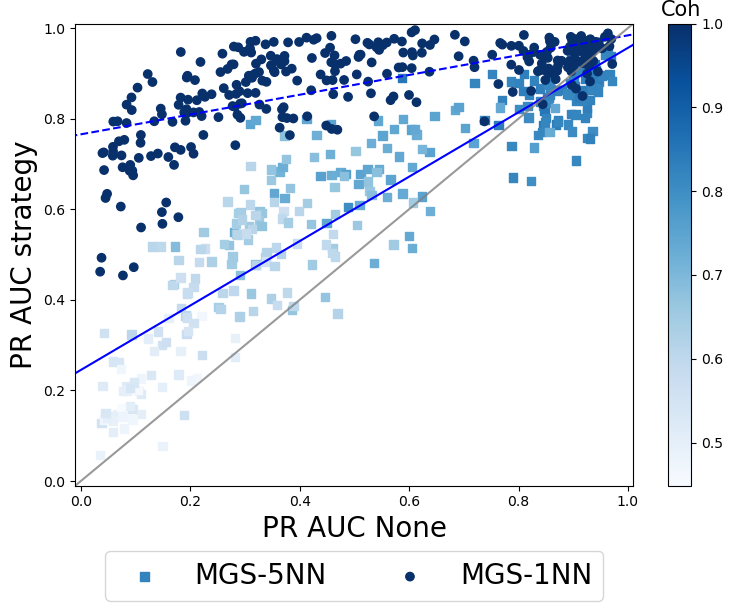

In [18]:
plt.figure(figsize=(9, 6))
zs = np.concatenate([1-array_ncss, 1-array_ncss_drf,], axis=0)
min_, max_ = zs.min(), zs.max()

plt.scatter(array_metric_none,array_metric_smote,label="MGS-5NN",c=1-array_ncss,cmap="Blues",marker='s')
plt.clim(min_, max_)
plt.scatter(array_metric_none,array_metric_drf,label="MGS-1NN",c=1-array_ncss_drf,cmap="Blues",marker='o') #RdYlGn
plt.clim(min_, max_)
#cax = fig.add_axes([0.94, 0.1, 0.05, 0.75])  # [left, bottom, width 5% of figure width, height 75% of figure height]
plt.colorbar().set_label('Coh',fontsize=15,labelpad=-30,y=1.05,rotation=0)
plt.plot(x_grid,pred_lin_reg_smote,c='blue',linestyle='-') #label="SMOTE-NC fit"


plt.plot(x_grid,pred_lin_reg_drf,c='blue',linestyle='--')  #label="MGS-GRF fit"
plt.plot(x_grid,x_grid,c='grey',alpha=0.8)


plt.xlabel("PR AUC None",fontsize=20)
plt.ylabel("PR AUC strategy",fontsize=20)
plt.title("")
plt.xlim([-0.01,1.01])
plt.ylim([-0.01,1.01])
plt.legend(bbox_to_anchor =(0.5,-0.28),ncol=4, loc='lower center',fontsize=20) #handlelength=0.5
plt.savefig("2025-images/sim2-normalv2-lin-2.pdf",bbox_inches='tight')
plt.show()

In [19]:
from sklearn.preprocessing import PolynomialFeatures

In [20]:
x_grid = np.arange(-0.1,1.1,0.01)
poly = PolynomialFeatures(degree=2)
array_metric_none_poly = poly.fit_transform(array_metric_none.reshape(-1, 1))
x_grid_poly = poly.transform(x_grid.reshape(-1, 1))
lin_reg_smote_poly = LinearRegression()
lin_reg_smote_poly.fit(array_metric_none_poly,array_metric_smote)
pred_lin_reg_poly_smote = lin_reg_smote_poly.predict(x_grid_poly)

In [21]:
x_grid = np.arange(-0.1,1.1,0.01)
poly = PolynomialFeatures(degree=2)
array_metric_none_poly = poly.fit_transform(array_metric_none.reshape(-1, 1))
x_grid_poly = poly.transform(x_grid.reshape(-1, 1))
lin_reg_drf_poly = LinearRegression()
lin_reg_drf_poly.fit(array_metric_none_poly,array_metric_drf)
pred_lin_reg_poly_drf = lin_reg_drf_poly.predict(x_grid_poly)

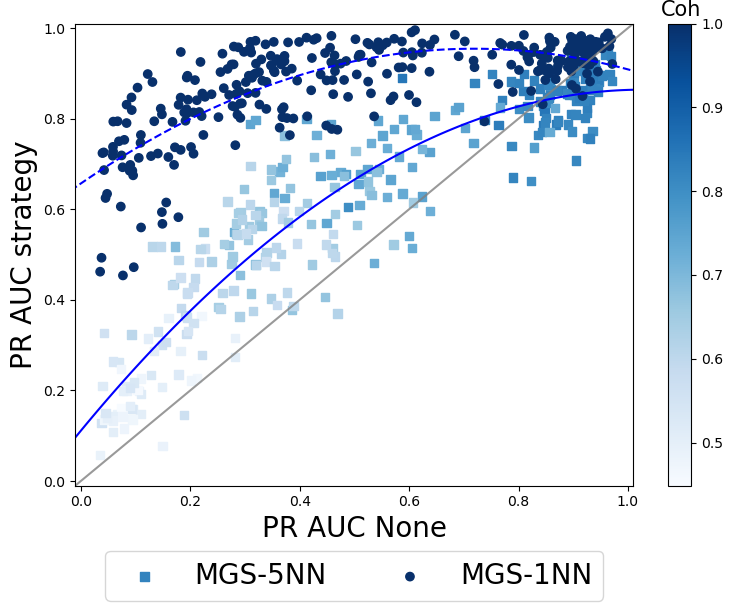

In [22]:
plt.figure(figsize=(9, 6))
zs = np.concatenate([1-array_ncss, 1-array_ncss_drf,], axis=0)
min_, max_ = zs.min(), zs.max()

plt.scatter(array_metric_none,array_metric_smote,label="MGS-5NN",c=1-array_ncss,cmap="Blues",marker='s')
plt.clim(min_, max_)
plt.scatter(array_metric_none,array_metric_drf,label="MGS-1NN",c=1-array_ncss_drf,cmap="Blues",marker='o') #RdYlGn
plt.clim(min_, max_)
#cax = fig.add_axes([0.94, 0.1, 0.05, 0.75])  # [left, bottom, width 5% of figure width, height 75% of figure height]
plt.colorbar().set_label('Coh',fontsize=15,labelpad=-30,y=1.05,rotation=0)
plt.plot(x_grid,pred_lin_reg_poly_smote,c='blue',linestyle='-') #label="SMOTE-NC fit"


plt.plot(x_grid,pred_lin_reg_poly_drf,c='blue',linestyle='--')  #label="MGS-GRF fit"
plt.plot(x_grid,x_grid,c='grey',alpha=0.8)


plt.xlabel("PR AUC None",fontsize=20)
plt.ylabel("PR AUC strategy",fontsize=20)
plt.title("")
plt.xlim([-0.01,1.01])
plt.ylim([-0.01,1.01])
plt.legend(bbox_to_anchor =(0.5,-0.28),ncol=4, loc='lower center',fontsize=20) #handlelength=0.5
plt.savefig("2025-images/sim2-normalv2-quadratic-2.pdf",bbox_inches='tight')
plt.show()

## Runing time derivation :

In [14]:
def average_runing_time(output_dir_path,init_name_file,n_iter=50):
    df_final = pd.DataFrame()
    for i in range(n_iter):
        name_file = init_name_file + str(i) + ".csv"
        curr_df = pd.read_csv(os.path.join(output_dir_path, "runtime" + name_file))
        df_final = pd.concat([df_final,curr_df],axis=0)
    return df_final.reset_index(drop=True)


In [9]:
df = average_runing_time(output_dir_path="../saved_experiments_categorial_features/2025-Sim2/normalv2/lgbm/5ksamples/case2/1000estimators/runtimejobs1",
                    init_name_file="2027-01-07-lgbm_",
                    n_iter=50)
df.mean(axis=0).to_frame().T.style.format(precision=2).highlight_max(props='font-weight:bold;color:#090E19', axis = 1)

,Unnamed: 0,None,CW,ROS,RUS,SmoteNC (K=5),MGS(mu)(d+1)(EmpCov) 1-NN,MGS(mu)(d+1)(EmpCov) 5-NN,MGS-NC(mu)(d+1)(EmpCov),MGS(mu)(d+1)(EmpCov) drf,MGS(mu)(d+1)(EmpCov) DRFsk classique (mtry=def=sqrt),MGS(mu)(d+1)(EmpCov) DRFskExtra classique (mtry=def=sqrt)
0,0.00,0.55,0.56,0.74,0.27,1.01,1.00,1.04,1.23,1.16,1.43,1.38


In [11]:
df.std(axis=0).to_frame().T.style.format(precision=2).highlight_max(props='font-weight:bold;color:#090E19', axis = 1)

,Unnamed: 0,None,CW,ROS,RUS,SmoteNC (K=5),MGS(mu)(d+1)(EmpCov) 1-NN,MGS(mu)(d+1)(EmpCov) 5-NN,MGS-NC(mu)(d+1)(EmpCov),MGS(mu)(d+1)(EmpCov) drf,MGS(mu)(d+1)(EmpCov) DRFsk classique (mtry=def=sqrt),MGS(mu)(d+1)(EmpCov) DRFskExtra classique (mtry=def=sqrt)
0,0.00,0.03,0.03,0.04,0.01,0.02,0.04,0.01,0.01,0.05,0.05,0.04


In [19]:
df = average_runing_time(output_dir_path="../saved_experiments_categorial_features/2025-Sim2/normalv2/lgbm/5ksamples/case2/1000estimators/runtimejobs1v2",
                    init_name_file="2027-01-07-lgbm_",
                    n_iter=50)
df.mean(axis=0).to_frame().T.style.format(precision=2).highlight_max(props='font-weight:bold;color:#090E19', axis = 1)

,Unnamed: 0,None,CW,ROS,RUS,SmoteNC (K=5),MGS(mu)(d+1)(EmpCov) 1-NN,MGS(mu)(d+1)(EmpCov) 5-NN,MGS-NC(mu)(5)(EmpCov),MGS-NC(mu)(d+1)(EmpCov),MGS(mu)(d+1)(EmpCov) DRFsk classique (mtry=def=sqrt)
0,0.00,0.54,0.56,0.73,0.27,0.99,0.99,1.02,1.22,1.22,1.43


In [20]:
df.std(axis=0).to_frame().T.style.format(precision=2).highlight_max(props='font-weight:bold;color:#090E19', axis = 1)

,Unnamed: 0,None,CW,ROS,RUS,SmoteNC (K=5),MGS(mu)(d+1)(EmpCov) 1-NN,MGS(mu)(d+1)(EmpCov) 5-NN,MGS-NC(mu)(5)(EmpCov),MGS-NC(mu)(d+1)(EmpCov),MGS(mu)(d+1)(EmpCov) DRFsk classique (mtry=def=sqrt)
0,0.00,0.03,0.03,0.04,0.02,0.02,0.04,0.01,0.01,0.01,0.05


## Plot samp ratio :

In [4]:
def compute_runs_over_samp(list_samps,strategies,init_output_dir_path,init_name_file,n_iter=20,n_fold=5):
    array_res_mean = np.zeros((len(list_samps),len(strategies)))
    array_res_std = np.zeros((len(list_samps),len(strategies)))
    
    for i,samp in enumerate(list_samps) :
        output_dir_path =init_output_dir_path +str(samp)
        df_final_mean,df_final_std = compute_metrics_several_protocols(
            output_dir=output_dir_path,
            init_name_file=init_name_file,
            list_metric=list_metric,
            bool_roc_auc_only=False,n_iter=n_iter,n_fold=n_fold)
        for j,strat in enumerate(strategies) :
            array_res_mean[i,j] = df_final_mean.loc['avg_pr_auc'][strat]
            array_res_std[i,j] = df_final_std.loc['avg_pr_auc'][strat]
    
    array_res_mean_with_dim = np.hstack((np.array(list_samps).reshape(-1,1),array_res_mean))
    array_res_std_with_dim = np.hstack((np.array(list_samps).reshape(-1,1),array_res_std))
    columns_with_dim = ['n_samples_min']
    columns_with_dim.extend(strategies)
    df_res_mean= pd.DataFrame(array_res_mean_with_dim,columns=columns_with_dim)
    df_res_std= pd.DataFrame(array_res_std_with_dim,columns=columns_with_dim)
    return df_res_mean,df_res_std
    
def plot_(df,df_std,xlim=[-0.1,510],ylim=[0.55,1.0],fontsize=20,plot_error_fill=False,title='',
         name_strats_to_plot= None,to_save=False,name_file_saving='img.pdf'):
    plt.figure(figsize=(12,8))
    list_start = df.columns.tolist()[1:]
    list_fmt= ['o','v','^','s','*','8']*((len(list_start) // 6)+1)
    list_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
                   '#7f7f7f', '#bcbd22', '#17becf'] *((len(list_start) // 10)+1)
    for i,strat in enumerate(list_start):
        if plot_error_fill:
            if name_strats_to_plot :
                name_strat= name_strats_to_plot[i]
            else:
                name_strat=strat
            #plt.errorbar(df[['n_samples_min']].values.ravel(),df[[strat]].values.ravel(),
            #                 yerr=df_std[[strat]].values.ravel(),fmt=list_fmt[i], markersize=3,elinewidth=0.5, capsize=6,label=name_strat
            #                )
            plt.plot(df[['n_samples_min']].values.ravel(),df[[strat]].values.ravel(), 
                     marker=list_fmt[i],linestyle="--", label=name_strat,c=list_colors[i],
                    )
            plt.fill_between(df[['n_samples_min']].values.ravel(),df[[strat]].values.ravel()- df_std[[strat]].values.ravel(),
                             df[[strat]].values.ravel()+ df_std[[strat]].values.ravel(),color=list_colors[i], alpha=0.2
                            )
        else:
            plt.plot(df[['n_samples_min']],df[[strat]],linestyle="--")
            plt.scatter(df[['n_samples_min']],df[[strat]],label=strat)

    plt.axvline(x = 3600, color = 'gray',alpha=0.8, label = 'Equilibrium')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title(title,fontsize=fontsize)
    plt.xlabel("n final",fontsize=fontsize)
    plt.ylabel("PR AUC",fontsize=fontsize)
    #plt.legend(fontsize=fontsize)
    plt.legend(bbox_to_anchor =(0.5,-0.38),ncol=3, loc='lower center',fontsize=fontsize)
    if to_save:
        plt.savefig(name_file_saving,bbox_inches='tight')
    plt.show()

In [5]:
df_res_mean,df_res_std = compute_runs_over_samp(list_samps=[200, 750, 1000, 1500, 2000, 2500, 3000, 3600, 5000], 
                             strategies=['None','SmoteNC (K=5)','MGS(mu)(d+1)(EmpCov) 1-NN',
                                         'MGS(mu)(d+1)(EmpCov) 5-NN','MGS(mu)(d+1)(EmpCov) DRFsk classique (mtry=def=sqrt)',],
                             init_output_dir_path="../saved_experiments_categorial_features/2025-Sim2/samp_strategy/normalv2/lgbm/5ksamples/case6/",
                             init_name_file='2027-01-07-lgbm_', n_fold=1,n_iter=50)

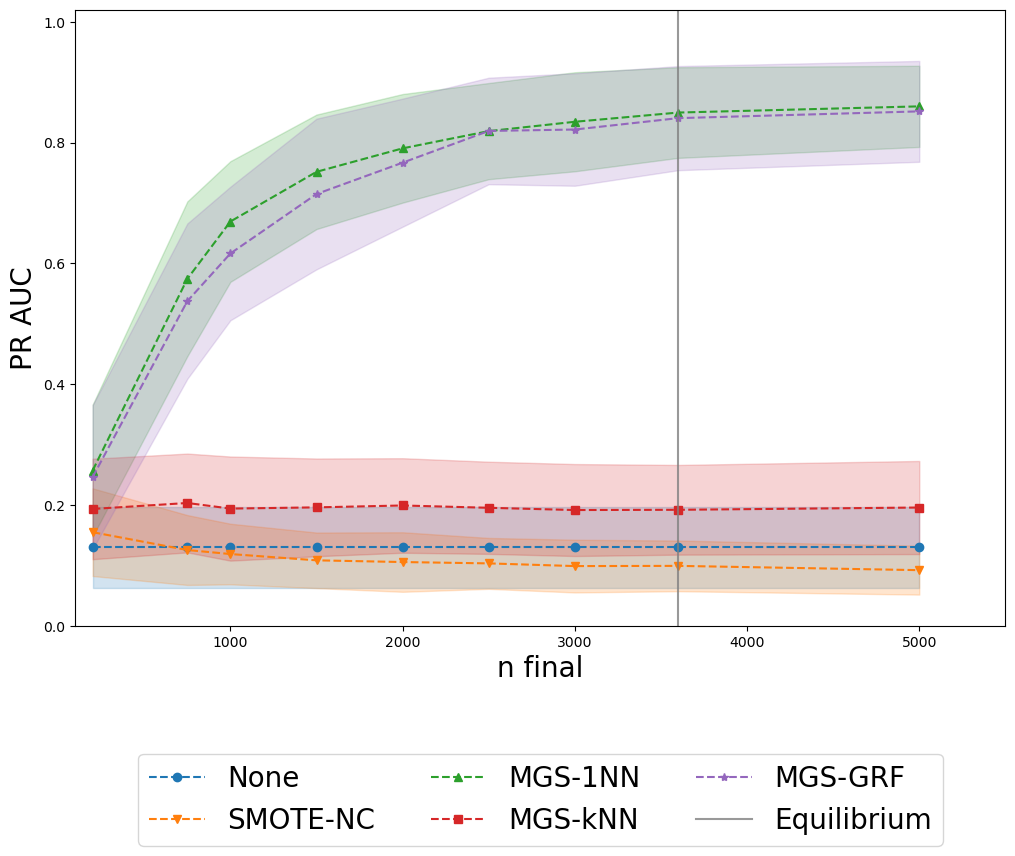

In [6]:
plot_(df=df_res_mean,
      df_std=df_res_std,
      xlim=[100,5500],ylim=[0.,1.02],plot_error_fill=True,fontsize=20,
     name_strats_to_plot =['None','SMOTE-NC','MGS-1NN','MGS-kNN','MGS-GRF'],
     title="",to_save=True,name_file_saving='2025-images/sim1-samp-ratio.pdf')

In [11]:
df_res_mean,df_res_std = compute_runs_over_samp(list_samps=[450, 750, 1000, 1500, 2000, 2500, 3000, 3600, 5000, 6000], 
                             strategies=['None','SmoteNC (K=5)','MGS(mu)(d+1)(EmpCov) 1-NN',
                                         'MGS(mu)(d+1)(EmpCov) 5-NN','MGS(mu)(d+1)(EmpCov) DRFsk classique (mtry=def=sqrt)',],
                             init_output_dir_path="../saved_experiments_categorial_features/2025-Sim2/samp_strategy/normalv2/lgbm/5ksamples/case4/",
                             init_name_file='2027-01-07-lgbm_', n_fold=1,n_iter=50)

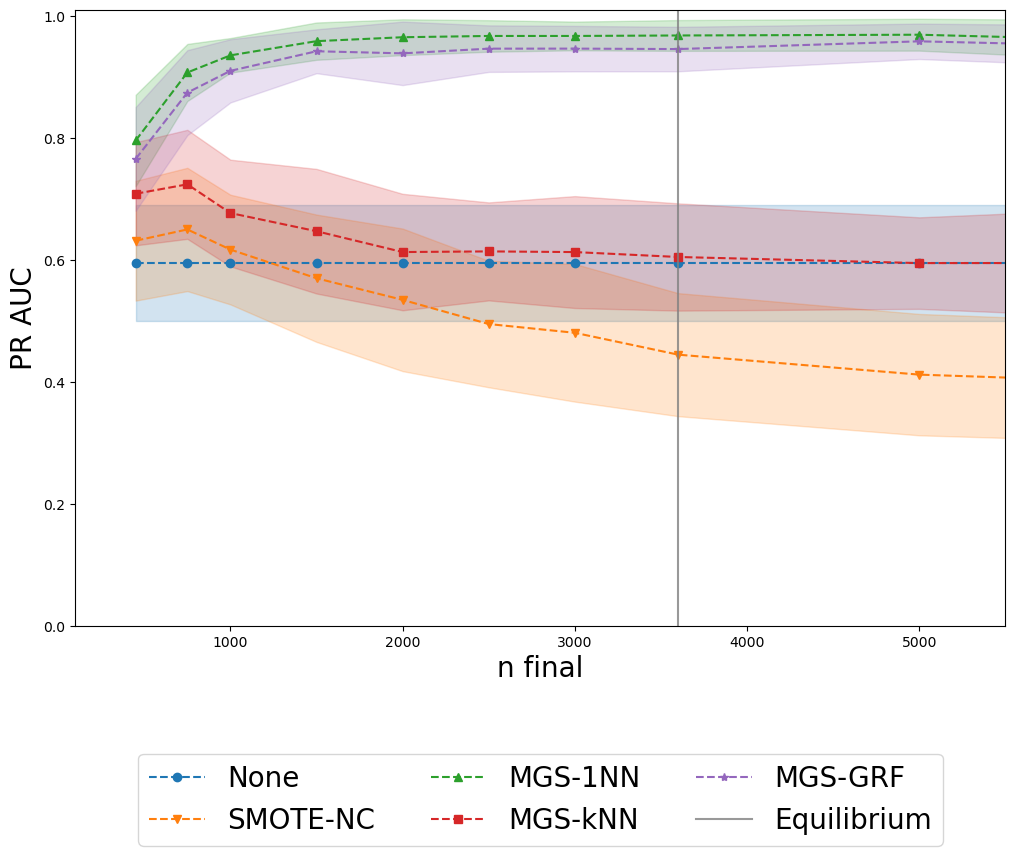

In [12]:
plot_(df=df_res_mean,
      df_std=df_res_std,
      xlim=[100,5500],ylim=[0.,1.01],plot_error_fill=True,fontsize=20,
     name_strats_to_plot =['None','SMOTE-NC','MGS-1NN','MGS-kNN','MGS-GRF'],
     title="",to_save=True,name_file_saving='2025-images/sim1-samp-ratio.pdf')

In [9]:
df_res_mean,df_res_std = compute_runs_over_samp(list_samps=[450, 750, 1000, 1500, 2000, 2500, 3000, 3600, 5000, 6000], 
                             strategies=['None','SmoteNC (K=5)','MGS(mu)(d+1)(EmpCov) 1-NN',
                                         'MGS(mu)(d+1)(EmpCov) 5-NN','MGS(mu)(d+1)(EmpCov) DRFsk classique (mtry=def=sqrt)',],
                             init_output_dir_path="../saved_experiments_categorial_features/2025-Sim2/samp_strategy/normalv2/lgbm/5ksamples/case5/",
                             init_name_file='2027-01-07-lgbm_', n_fold=1,n_iter=50)

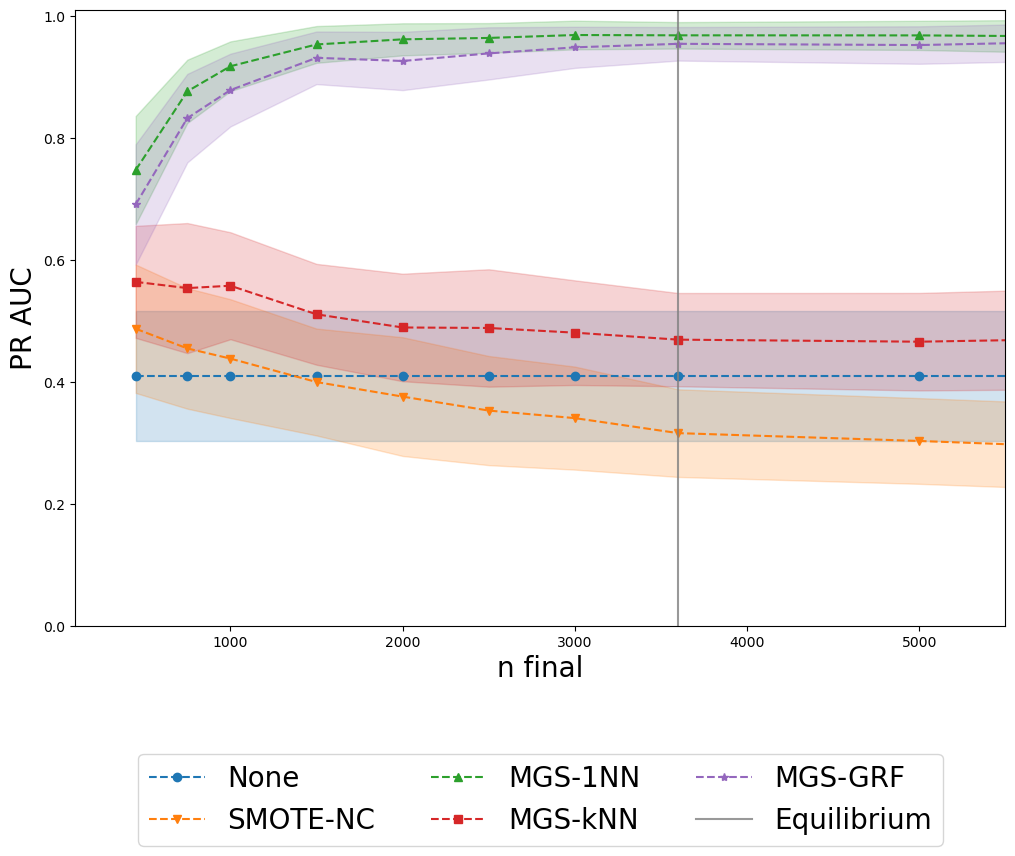

In [10]:
plot_(df=df_res_mean,
      df_std=df_res_std,
      xlim=[100,5500],ylim=[0.,1.01],plot_error_fill=True,fontsize=20,
     name_strats_to_plot =['None','SMOTE-NC','MGS-1NN','MGS-kNN','MGS-GRF'],
     title="",to_save=True,name_file_saving='2025-images/sim1-samp-ratio.pdf')